In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [3]:
col_names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "type"]
dataset = pd.read_csv("iris.csv", skiprows=1, names=col_names, header=None)
dataset.head(10)

,sepal_length,sepal_width,petal_length,petal_width,type
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
5,5.4,3.9,1.7,0.4,Setosa
6,4.6,3.4,1.4,0.3,Setosa
7,5.0,3.4,1.5,0.2,Setosa
8,4.4,2.9,1.4,0.2,Setosa
9,4.9,3.1,1.5,0.1,Setosa


In [4]:
##Giving numbers to different types
types = dataset['type']

label_encoder = LabelEncoder()
# Fit and transform the 'type' column
encoded_types = label_encoder.fit_transform(types)

# Replace the original 'type' column with the encoded values
dataset['type'] = encoded_types

print(dataset['type'].unique())

[0 1 2]


In [5]:
X =dataset.iloc[:,: -1]
y = dataset.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=43)

In [8]:
import numpy as np
import pandas as pd
import time


##TREE NODE

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value


class DecisionTreeClassifier:
    def __init__(self, minimum_samples_split=2, max_depth=2):
        self.root = None

        self.minimum_samples_split = minimum_samples_split
        self.max_depth = max_depth

    def __build_tree(self, ds, curr_depth=0):
        x_data, y_data = ds.iloc[:, :-1], ds.iloc[:, -1]
        num_samples, num_features = np.shape(x_data)

        if num_samples >= self.minimum_samples_split and curr_depth <= self.max_depth:

            splitted_data = self.__get_best_split(ds, num_samples, num_features)

            if splitted_data["info_gain"] > 0:
                left_sub_tree = self.__build_tree(splitted_data['dataset_left'], curr_depth + 1)
                right_sub_tree = self.__build_tree(splitted_data['dataset_right'], curr_depth + 1)

                return Node(splitted_data['feature_index'], splitted_data['threshold'], left_sub_tree, right_sub_tree,
                            splitted_data['info_gain'], )
        leaf_value = self.__calculate_leaf_node(y_data)
        return Node(value=leaf_value)
            

    def __get_best_split(self, ds, num_samples, num_features):

        max_info_gain = -float("inf")
        best_split = {}

        for feature_index in range(num_features):
            feature_values = ds.iloc[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.__split(ds, feature_index, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y_data, left_y, right_y = ds.iloc[:, -1], dataset_left.iloc[:, -1], dataset_right.iloc[:, -1]
                    # compute information gain
                    curr_info_gain = self.__information_gain(y_data, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split

    def __split(self, ds, feature_index, threshold):
        left_data = ds.loc[(ds.iloc[:, feature_index] <= threshold)]
        right_data = ds.loc[(ds.iloc[:, feature_index] > threshold)]
        return left_data, right_data

    def __information_gain(self, parent_dataset, left_dataset, right_dataset, mode="entropy"):
        l_weight = len(left_dataset) / len(parent_dataset)
        r_weight = len(right_dataset) / len(parent_dataset)

        gain = self.__gini_index(parent_dataset) - l_weight * self.__gini_index(left_dataset) - r_weight * self.__gini_index(
            right_dataset)
        return gain

    def __gini_index(self, y_data):
        class_labels = np.unique(y_data)
        gini = 0
        for cls in class_labels:
            p_cls = len(y_data[y_data == cls]) / len(y_data)
            gini += p_cls ** 2
        return 1 - gini

    def __calculate_leaf_node(self, y_data):
        y_data = list(y_data)
        return max(y_data, key=y_data.count)
    def print_tree(self):
        self.print_the_dt_tree(self.root)
        
    def print_the_dt_tree(self, tr=None, indent=" "):
        
        if tr is not None:
            if tr.value is not None:
                print(tr.value)
            else:
                print("X_"+str(tr.feature_index), "<=", tr.threshold, "?", tr.info_gain)
                print("%sleft:" % (indent), end="")
                self.print_the_dt_tree(tr.left, indent + indent)
                print("%sright:" % (indent), end="")
                self.print_the_dt_tree(tr.right, indent + indent) 

    def fit(self, ds):
        self.root = self.__build_tree(ds)

    def single_predict(self, row):
        return self.make_prediction(row, self.root)

    def predict(self, x_data):

        predictions = [self.make_prediction(row, self.root) for row in x_data.values]
        return predictions

    def make_prediction(self, row, tr):

        if tr is not None and tr.value is not None:
            # print(tree.value)
            return tr.value
        if tr is None:
            return None
        feature_val = row[tr.feature_index]
        # print(str(feature_val)+" --- "+str(tree.feature_index))
        if feature_val <= float(tr.threshold):
            return self.make_prediction(row, tr.left)
        else:
            return self.make_prediction(row, tr.right)
    def accuracy_score(self, y_pred, y_test):
        count = 0
        if len(y_test) != len(y_pred):
            print("not same size")
            return

        for i in range(len(y_test)):
            if y_test[i] == y_pred[i]:
                count += 1

        print(count / len(y_test))


In [9]:
#my classifier

decisionTree = DecisionTreeClassifier(minimum_samples_split=3,max_depth=3)
train_data =pd.concat((X_train,y_train),axis=1)
decisionTree.fit(train_data)
decisionTree.print_tree()


X_2 <= 1.9 ? 0.32716836734693866
 left:0
 right:X_2 <= 4.8 ? 0.37944250871080143
  left:X_0 <= 4.9 ? 0.05551020408163265
    left:2
    right:1
  right:X_3 <= 1.7 ? 0.09246196991586637
    left:X_2 <= 4.9 ? 0.14693877551020418
        left:1
        right:2
    right:2


0.9210526315789473
0.9210526315789473


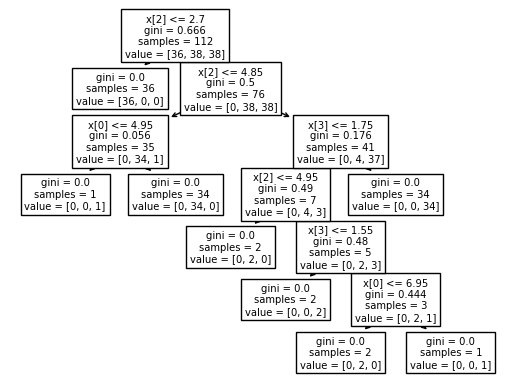

In [10]:
y_pred = decisionTree.predict(X_test)

from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)
y2_pred = dt.predict(X_test)

tree.plot_tree(dt)

decisionTree.accuracy_score(y_pred,y_test.values)
decisionTree.accuracy_score(y2_pred,y_test.values)